In [1]:
import torch
from torch import nn, onnx
from torch.nn import functional as F
from torch.optim import Adam
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
def normalize(table: pd.Series) -> torch.Tensor:
    table = table.apply(lambda x: int(x.replace("#", "").replace("\ufeff", "")))
    table = torch.from_numpy(table.to_numpy())

    # От куда я взял эти числа смотри в analis.ipynb
    table[table < -1192] = -1192
    table[table >  1217] =  1217
    table = table - 10.31
    table = table / 1206.7

    return table

In [3]:
def parse_fen(table: pd.Series) -> torch.Tensor:
    # Переписать на регулярки?
    x = []

    for txt in tqdm(table, "Parse FEN"):
        fen, tour = txt.split(" ")[:2]
        fen = fen.replace("/", "")\
            .replace("1", ".")\
            .replace("2", "..")\
            .replace("3", "...")\
            .replace("4", "....")\
            .replace("5", ".....")\
            .replace("6", "......")\
            .replace("7", ".......")\
            .replace("8", "........")

        hot = torch.zeros(770, dtype=torch.uint8)  # 12 * 8 * 8 + 2
        for idx, sym in enumerate(fen):
            match sym:
                case "r": hot[idx*12 +  0] = 1
                case "n": hot[idx*12 +  1] = 1
                case "b": hot[idx*12 +  2] = 1
                case "q": hot[idx*12 +  3] = 1
                case "k": hot[idx*12 +  4] = 1
                case "p": hot[idx*12 +  5] = 1
                case "R": hot[idx*12 +  6] = 1
                case "N": hot[idx*12 +  7] = 1
                case "B": hot[idx*12 +  8] = 1
                case "Q": hot[idx*12 +  9] = 1
                case "K": hot[idx*12 + 10] = 1
                case "P": hot[idx*12 + 11] = 1
                case ".": continue

        if tour == "b":
            hot[768] = 1
        else:
            hot[769] = 1
        x.append(hot)

    return torch.stack(x).type(torch.float)

In [4]:
def read_data(path: str,
              batch: int = 64,
              device: str = "cpu") -> "generator":
    table = pd.read_csv(path)
    fen = parse_fen(table.FEN).to(device)  # Очень долго, переписать
    eva = normalize(table.Evaluation).to(device)

    rand = torch.randperm(fen.size(0))
    fen = fen[rand]
    eva = eva[rand]
    max_n = round(fen.shape[0] / batch + 0.5)
    n = 0

    while True:
        if (n == max_n):
            rand = torch.randperm(len(fen))
            fen = fen[rand]
            eva = eva[rand]
            n = 0
        else:
            n += 1

        x = fen[batch * n:batch * (n + 1)]
        y = eva[batch * n:batch * (n + 1)]
        yield (x, y)

In [5]:
class ChessAI(nn.Module):
    def __init__(self):
        super().__init__()
        self.hot = nn.Linear(770, 20, bias=False)
        self.fc = nn.Sequential(
            nn.Linear(20, 10, bias=False), nn.ReLU(),
            nn.Linear(10,  5, bias=False), nn.ReLU(),
            nn.Linear( 5,  1, bias=False), nn.Softsign(),
        )
        # Всего 1555 обучаеммых параметров с оптимизацией на emb!!! (?)

    def forward(self, inp: torch.Tensor) -> torch.Tensor:
        inp = self.hot(inp)
        out = self.fc(inp)

        return out.squeeze(-1)

In [6]:
def train(model: ChessAI,
          optimizer: Adam,
          data: "generator",
          loops: int = 64) -> list[float]:
    model.train()
    history = []

    for _ in tqdm(range(loops), "Train model"):
        x, y = next(data)
        out = model(x)
        loss = F.mse_loss(out, y)

        loss.backward()
        optimizer.step()
        model.zero_grad()

        history.append(loss.item())

    plt.plot(history)
    return history

In [7]:
bot = ChessAI().to("cuda")
optim = Adam(
    bot.parameters(),
    lr=1e-4,
)
data = read_data(
    path="/content/drive/MyDrive/data/chessEval/random_evals.csv",
    batch=128,
    device="cuda",
)
_ = next(data)

Parse FEN: 100%|██████████| 1000273/1000273 [03:07<00:00, 5342.87it/s]


Train model: 100%|██████████| 262144/262144 [06:52<00:00, 635.11it/s]


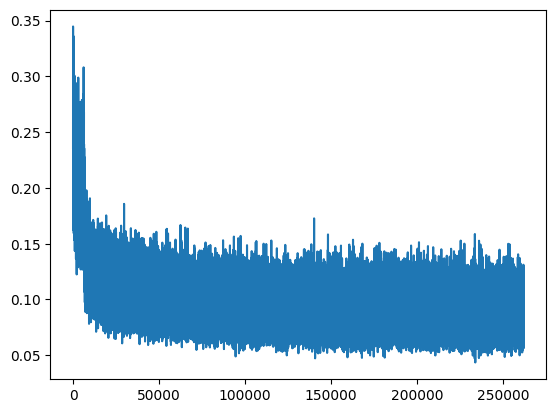

In [8]:
hist = train(
    model=bot,
    optimizer=optim,
    data=data,
    loops=2**18,
)

In [10]:
# Сохранение модели в формате onnx
bot.eval()
input = _[0]

onnx.export(
    model = bot,
    args = input,
    f = "ChessBot.onnx",
    export_params = True,
    verbose = True,
    input_names = ["One-Hot input"],
    output_names = ["Position assessment"],
)